In [1]:
# IMPORTS
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import libs.forward_model as fm
import libs.read_data as rd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
torch.cuda.is_available()

True

In [2]:
# Parameter Definition
NA = .5
Rindex= 1
lambda_= 532.0/ 1000 #um
dx= 2.0 #um
dy= 2.0 #um
dz= 2.0 #um

Nx,Ny,Nz = 121,121,121

ep_dx = 6   
ep_dy = 6

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD(ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz)

c:\Python311\cv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


In [3]:
cam_dYdt_dark = .005
cam_t_exp = 1
max_photons = 10000
N_reps = 200
cam_alpha = .01
cam_sigma_read = 0.005
cam_EM_gain = 32

Shapes of vectors
 exPSF: torch.Size([3, 121, 121, 121])
 H1: torch.Size([3, 121, 121, 121])
 H2: torch.Size([121, 121, 121])
 emPSF: torch.Size([1, 121, 121, 121])
 H3: torch.Size([1, 121, 121, 121])


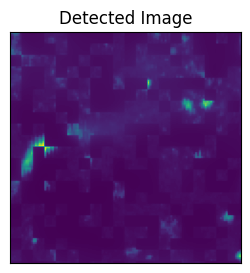

In [6]:
rd.load_object("blood_cell")   # Data Choices --> [blood_cell, neural_cell, bead, 3D_sphere]
det_img_orig = fm.forward_model(rd.X, verbose=1)

In [7]:
print(det_img_orig)
print(det_img_orig.max(),det_img_orig.min())

tensor([[0.4402, 0.5599, 0.7207,  ..., 0.0846, 0.0901, 0.1399],
        [0.2087, 0.2907, 0.4812,  ..., 0.0847, 0.0904, 0.1332],
        [0.1642, 0.2065, 0.3785,  ..., 0.0857, 0.0916, 0.1871],
        ...,
        [0.1428, 0.1581, 0.1312,  ..., 0.3815, 0.6912, 1.0138],
        [0.1386, 0.1444, 0.1381,  ..., 0.1281, 0.1976, 0.4129],
        [0.1033, 0.1054, 0.1071,  ..., 0.0860, 0.0918, 0.1510]])
tensor(1.8180) tensor(0.0216)


In [8]:
def simulateNoise(max_photons, N_reps, cam_alpha, cam_EM_gain):
    in_photons = torch.arange(max_photons*2)
    em_hist = in_photons.repeat(N_reps, 1).t()

    for i in range(1, cam_EM_gain):
        em_hist = em_hist + torch.binomial(em_hist.type(torch.float64), torch.tensor(cam_alpha).type(torch.float64))

    np.save('em_hist', em_hist.numpy())

    return em_hist.type(torch.long)

In [22]:
def noiseModel(det_Y,em_hist):

    N_reps = em_hist.shape[0]
    max_photons = em_hist.shape[1]

    detY = det_Y*max_photons

    # Dark Noise Model
    Ydark   = cam_dYdt_dark * cam_t_exp
    noise_Y    = torch.poisson(det_Y + Ydark)

    

    noise_Y[noise_Y > max_photons] = max_photons

    orig_shape = noise_Y.shape
    
    noise_Y = noise_Y.type(torch.long)

    for i in range(orig_shape[0]):
        for j in range(orig_shape[1]):
            noise_Y[i][j] = np.random.choice(em_hist[noise_Y[i][j]])
            
    noise_Y    = (noise_Y + torch.normal(mean = 0.,std=cam_sigma_read,size = orig_shape))

    return noise_Y

    # EM process Simulation

In [23]:
em_hist = simulateNoise(max_photons,N_reps,cam_alpha,cam_EM_gain)
print(em_hist.shape)

torch.Size([300, 200])


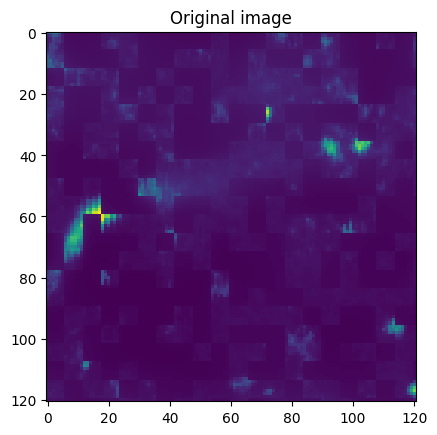

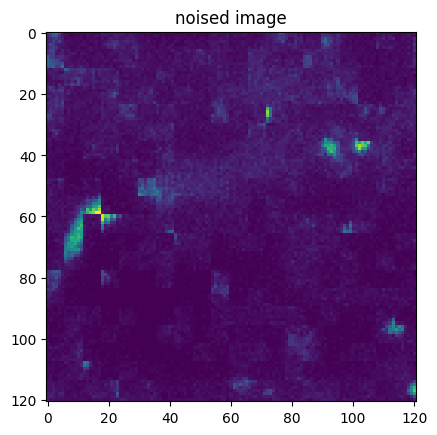

In [24]:
import matplotlib.pyplot as plt
from PIL import Image


plt.imshow(det_img_orig) 
plt.title('Original image')
plt.show()

noised_image = noiseModel(det_img_orig,em_hist)

plt.imshow(noised_image)
plt.title('noised image')
plt.show()

In [26]:
print(det_img_orig.min())
print(noised_image.max())

tensor(0.0216)
tensor(283.0075)


In [27]:
def direct_noiseModel(det_Y,max_photons,cam_EM_gain,cam_sigma_read,cam_alpha,cam_dYdt_dark,cam_t_exp):

    det_Y = (det_Y - det_Y.min())/(det_Y.max() - det_Y.min())*max_photons

    # Dark Noise Model
    Ydark   = cam_dYdt_dark * cam_t_exp
    noise_Y    = torch.poisson(det_Y + Ydark)

    for i in range(cam_EM_gain):
        noise_Y = noise_Y + torch.binomial(noise_Y , torch.tensor([cam_alpha]))



    noise_Y    = (noise_Y + torch.normal(mean = 0., std=cam_sigma_read,size = noise_Y.shape))/max_photons

    return noise_Y

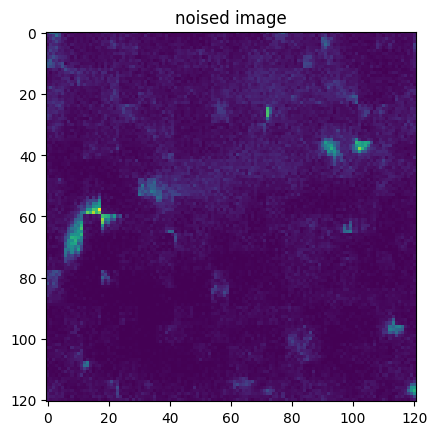

In [28]:
import matplotlib.pyplot as plt
from PIL import Image



noised_image = direct_noiseModel(det_img_orig,max_photons,cam_EM_gain,cam_sigma_read,cam_alpha,cam_dYdt_dark,cam_t_exp)

plt.imshow(noised_image)  # You can choose a different colormap if you prefer
plt.title('noised image')
plt.show()